In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

In [15]:
df = pd.read_csv('/content/drive/MyDrive/panaderias_meta_california.csv')
df.head()

,name,address,latitude,longitude,category,avg_rating,num_of_reviews,price,state,url
0,La California Bakery,"La California Bakery, 17351 Valley Blvd, La Pu...",34.011104,-117.925693,Bakery,1.0,1,NaN,Closed ⋅ Opens 5AM Thu,https://www.google.com/maps/place//data=!4m2!3...
1,Rafi's Pastry,"Rafi's Pastry, 1250 W Glenoaks Blvd # B, Glend...",34.165943,-118.283221,"Cake shop, Wedding bakery",5.0,8,NaN,Closed ⋅ Opens 9:30AM Thu,https://www.google.com/maps/place//data=!4m2!3...
2,Schwartz Bakery,"Schwartz Bakery, 1730 Cordova St, Los Angeles,...",34.038774,-118.295505,Bakery,4.4,8,NaN,Closes soon ⋅ 6PM ⋅ Opens 8:30AM Thu,https://www.google.com/maps/place//data=!4m2!3...
3,La Matcha Cafe,"La Matcha Cafe, 1828 El Camino Real UNIT 102, ...",37.595535,-122.383813,"Lunch restaurant, Bakery, Breakfast restaurant...",4.9,28,NaN,Closed ⋅ Opens 9:30AM Thu,https://www.google.com/maps/place//data=!4m2!3...
4,Wetzel's Pretzels,"Wetzel's Pretzels, 7537 Carson Blvd, Long Beac...",33.830058,-118.087402,"Pretzel store, Bakery",3.0,5,$,Permanently closed,https://www.google.com/maps/place//data=!4m2!3...


In [16]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [17]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5537 entries, 0 to 5536
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   name            5537 non-null   object 
 1   address         5502 non-null   object 
 2   latitude        5537 non-null   float64
 3   longitude       5537 non-null   float64
 4   category        5537 non-null   object 
 5   avg_rating      5537 non-null   float64
 6   num_of_reviews  5537 non-null   int64  
 7   price           3339 non-null   object 
 8   state           4246 non-null   object 
 9   url             5537 non-null   object 
dtypes: float64(3), int64(1), object(6)
memory usage: 432.7+ KB
None


##  Análisis de Datos y Metadatos

### Columnas y descripción (metadatos)
- **index**: identificador único de la fila.  
- **name**: nombre del negocio.  
- **address**: dirección completa del establecimiento.  
- **latitude**: latitud geográfica.  
- **longitude**: longitud geográfica.  
- **category**: categoría o tipo de negocio.  
- **avg_rating**: calificación promedio (1–5).  
- **num_of_reviews**: cantidad de reseñas.  
- **price**: rango de precios ($, $$, $$$).  
- **state**: estado del negocio (ej. “Closed ⋅ Opens 5AM”, “Permanently closed”).  
- **url**: enlace de Google Maps.  

### Tipos de datos
- **Categóricos**: `name`, `address`, `category`, `price`, `state`, `url`.  
- **Numéricos**: `latitude`, `longitude`, `avg_rating`, `num_of_reviews`.  
- **Índice**: `index`.  

### Valores faltantes y problemas
- `price` tiene muchos valores faltantes (NaN).  
- `state` no está estandarizado (mezcla horarios, cerrado permanente, etc.).  
- `category` tiene varias categorías en una sola celda.  
- Hay duplicados de negocios en el dataset.  

### Tamaño y estructura
- Cada fila representa un **negocio de panadería en California**.  
- Contiene datos geográficos, comerciales y de reputación.  

### Interpretación de variables para negocio
- `avg_rating` y `num_of_reviews` → reputación/popularidad.  
- `price` → nivel de precios (bajo, medio, alto).  
- `state` → estado operativo del negocio (abierto, cerrado temporal, cerrado permanente).  
- `latitude` y `longitude` → ubicación, útil para mapas y análisis de clusters.  
- `category` → clasificación de tipo de panadería o negocio.  


### Procesamiento de datos


In [18]:
# 1) Eliminar duplicados por combinación name + address
df = df.drop_duplicates(subset=["name", "address"])

In [19]:
# 2) Imputación de 'price' usando promedio de reviews por nivel de precio ($, $$, $$$)
#    a) Calcular promedio de reseñas por price para las filas con price conocido
price_reviews_mean = (
    df.dropna(subset=["price"])
      .groupby("price")["num_of_reviews"]
      .mean()
      .to_dict()
)

#    b) Definir umbrales de decisión:
#       - Si hay '$$' en el dataset conocido, usar su promedio como umbral;
#       - Si no, usar el promedio global de 'num_of_reviews' como fallback.
global_reviews_mean = df["num_of_reviews"].mean()
threshold_for_medium = price_reviews_mean.get("$$", global_reviews_mean)

def impute_price_by_reviews(row):
    if pd.isna(row["price"]):
        return "$$" if row["num_of_reviews"] > threshold_for_medium else "$"
    return row["price"]

df["price"] = df.apply(impute_price_by_reviews, axis=1)

price_map = {"$": "low", "$$": "medium", "$$$": "high"}
df["price"] = df["price"].map(price_map).fillna("unknown")


In [20]:
# 3) Normalizar 'state' en 4 categorías
def clean_state(x):
    if pd.isna(x):
        return "unknown"
    s = str(x).lower()
    if "permanently closed" in s:
        return "permanently_closed"
    # 'closed' sin 'permanently' => cerrado temporal
    if "closed" in s and "permanently" not in s:
        return "closed_temp"
    # abierto o con horario (open/closes/opens)
    if "open" in s or "closes" in s or "opens" in s:
        return "open"
    return "unknown"

df["state"] = df["state"].apply(clean_state)


In [21]:

# 4) Crear 'main_category' tomando la primera categoría listada
df["main_category"] = df["category"].apply(lambda x: str(x).split(",")[0].strip())


In [22]:
# 5) Rellenar 'address' faltante
df["address"] = df["address"].fillna("unknown address")

In [23]:
# 6) Resetear índice para conservar los indices orginales
df = df.reset_index(drop=True)

###Explicación:

```
  name
0    A
1    B
2    C
```


```
df = df.drop(1)
print(df)
```
Output:


```
  name
0    A
2    C
```
```
df = df.reset_index(drop=True)
print(df)
```
Output:


```
  name
0    A
1    C
```






In [24]:

# Revision despues del procesamiento de datos
print("Shape final:", df.shape)
print("\nTipos de datos:")
print(df.dtypes)

Shape final: (5523, 11)

Tipos de datos:
name               object
address            object
latitude          float64
longitude         float64
category           object
avg_rating        float64
num_of_reviews      int64
price              object
state              object
url                object
main_category      object
dtype: object


In [25]:
print("\nConteo price (low/medium/high/unknown):")
print(df["price"].value_counts(dropna=False))


Conteo price (low/medium/high/unknown):
price
low        3744
medium     1690
high         51
unknown      38
Name: count, dtype: int64


In [26]:
print("\nConteo state:")
print(df["state"].value_counts(dropna=False))



Conteo state:
state
closed_temp           2177
open                  1459
unknown               1291
permanently_closed     596
Name: count, dtype: int64


In [27]:
df.head(10)

,name,address,latitude,longitude,category,avg_rating,num_of_reviews,price,state,url,main_category
0,La California Bakery,"La California Bakery, 17351 Valley Blvd, La Pu...",34.011104,-117.925693,Bakery,1.0,1,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Bakery
1,Rafi's Pastry,"Rafi's Pastry, 1250 W Glenoaks Blvd # B, Glend...",34.165943,-118.283221,"Cake shop, Wedding bakery",5.0,8,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Cake shop
2,Schwartz Bakery,"Schwartz Bakery, 1730 Cordova St, Los Angeles,...",34.038774,-118.295505,Bakery,4.4,8,low,open,https://www.google.com/maps/place//data=!4m2!3...,Bakery
3,La Matcha Cafe,"La Matcha Cafe, 1828 El Camino Real UNIT 102, ...",37.595535,-122.383813,"Lunch restaurant, Bakery, Breakfast restaurant...",4.9,28,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Lunch restaurant
4,Wetzel's Pretzels,"Wetzel's Pretzels, 7537 Carson Blvd, Long Beac...",33.830058,-118.087402,"Pretzel store, Bakery",3.0,5,low,permanently_closed,https://www.google.com/maps/place//data=!4m2!3...,Pretzel store
5,Teres Bakery,"Teres Bakery, 1260 Long Beach Blvd, Long Beach...",33.782448,-118.189015,Bakery,4.4,15,low,permanently_closed,https://www.google.com/maps/place//data=!4m2!3...,Bakery
6,Express Bakery La Salvadoreña,"Express Bakery La Salvadoreña, 4250 Phelan Rd,...",34.426981,-117.569160,Bakery,4.9,15,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Bakery
7,Sadie Rose Baking Co,"Sadie Rose Baking Co, 2614 Temple Heights Dr, ...",33.214554,-117.267778,"Wholesale bakery, Bakery",4.4,18,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Wholesale bakery
8,Delcious Pastry & Bakery,"Delcious Pastry & Bakery, 2346 W Pico Blvd, Lo...",34.046909,-118.287994,Bakery,4.7,18,low,closed_temp,https://www.google.com/maps/place//data=!4m2!3...,Bakery
9,Panaderia Don Chava Bakery,"Panaderia Don Chava Bakery, 2828 Niles St, Bak...",35.376374,-118.955125,Bakery,3.7,18,low,permanently_closed,https://www.google.com/maps/place//data=!4m2!3...,Bakery


###EDA(Exploratory Data Analysis)


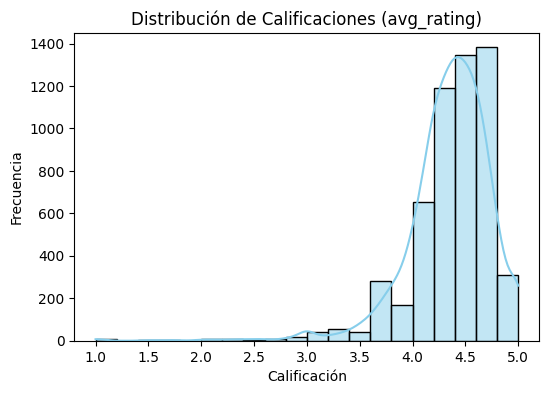

In [28]:
plt.figure(figsize=(6,4))
sns.histplot(df["avg_rating"], bins=20, kde=True, color="skyblue")
plt.title("Distribución de Calificaciones (avg_rating)")
plt.xlabel("Calificación")
plt.ylabel("Frecuencia")
plt.show()

La mayoría de las panaderías tienen calificaciones entre 4.0 y 5.0, lo que indica que en general los clientes valoran positivamente a estos negocios. Muy pocas panaderías tienen calificaciones menores a 3.0, lo que sugiere que los negocios con baja reputación son la excepción y no la regla.

/tmp/ipython-input-3172679381.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="price", data=df, order=["low","medium","high","unknown"], palette="pastel")


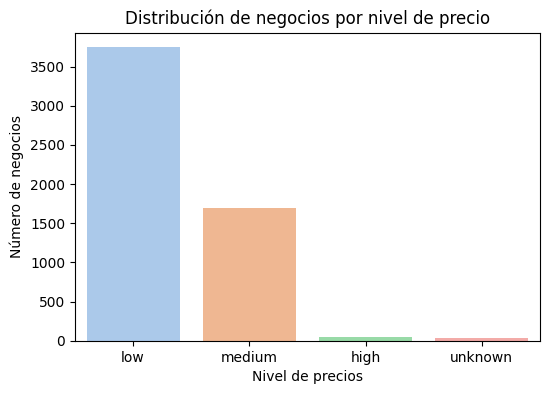

In [29]:
plt.figure(figsize=(6,4))
sns.countplot(x="price", data=df, order=["low","medium","high","unknown"], palette="pastel")
plt.title("Distribución de negocios por nivel de precio")
plt.xlabel("Nivel de precios")
plt.ylabel("Número de negocios")
plt.show()

Predominan las panaderías de precio bajo (low), con más de 3700 establecimientos. Las de precio medio (medium) representan un segundo grupo importante (~1690), mientras que las de precio alto (high) son muy pocas (apenas 51). Esto refleja que el mercado en California está dominado por opciones accesibles, con pocas panaderías de lujo.

/tmp/ipython-input-108161132.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="state", data=df, order=["open","closed_temp","permanently_closed","unknown"], palette="muted")


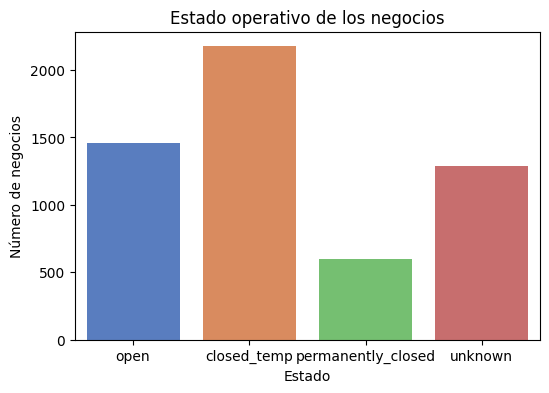

In [30]:
plt.figure(figsize=(6,4))
sns.countplot(x="state", data=df, order=["open","closed_temp","permanently_closed","unknown"], palette="muted")
plt.title("Estado operativo de los negocios")
plt.xlabel("Estado")
plt.ylabel("Número de negocios")
plt.show()

Una gran cantidad de negocios están marcados como cerrados temporalmente (closed_temp), lo cual puede deberse a horarios de Google Maps o cierres por temporada.

~1450 están abiertos actualmente, lo que representa una parte significativa pero menor al total.

~600 aparecen como cerrados permanentemente, lo que indica una tasa de mortalidad de negocios notable.

~1300 están en estado desconocido, probablemente porque la información no está disponible.


/tmp/ipython-input-150672193.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")


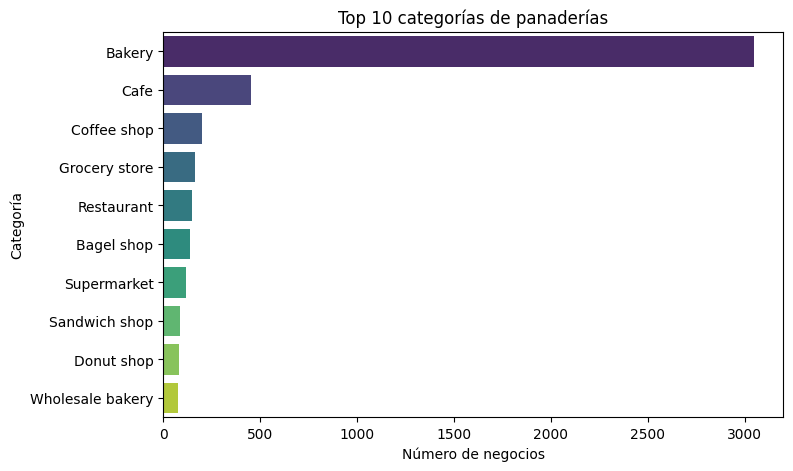

In [31]:
top_categories = df["main_category"].value_counts().nlargest(10)
plt.figure(figsize=(8,5))
sns.barplot(x=top_categories.values, y=top_categories.index, palette="viridis")
plt.title("Top 10 categorías de panaderías")
plt.xlabel("Número de negocios")
plt.ylabel("Categoría")
plt.show()

La gran mayoría están clasificadas  como “Bakery”, entonces significa que nuestro dataset es homogeneo.

 Sin embargo, también hay subcategorías como Cafe, Coffee shop, Grocery store, Restaurant, Bagel shop y Wholesale bakery, lo que muestra diversidad: algunas panaderías amplían su oferta con café, alimentos o venta mayorista.

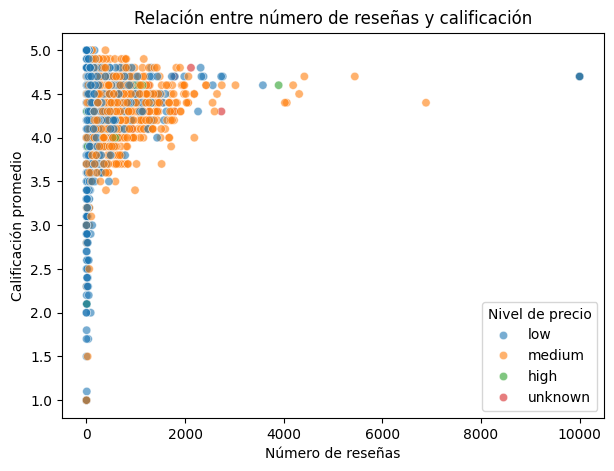

In [32]:
plt.figure(figsize=(7,5))
sns.scatterplot(x="num_of_reviews", y="avg_rating", hue="price", data=df, alpha=0.6)
plt.title("Relación entre número de reseñas y calificación")
plt.xlabel("Número de reseñas")
plt.ylabel("Calificación promedio")
plt.legend(title="Nivel de precio")
plt.show()

Existe una alta concentración de negocios con menos de 500 reseñas y calificaciones cercanas a 4–5 estrellas. Algunos negocios con miles de reseñas mantienen calificaciones altas, lo que indica consistencia en su calidad. No se observa una relación entre precio y calificación: panaderías de bajo y medio precio pueden tener valoraciones altas.

In [33]:
fig = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    color="price",
    hover_name="name",
    hover_data=["avg_rating","num_of_reviews","main_category","state"],
    zoom=5,
    height=500
)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(title="Ubicación de panaderías en California (coloreadas por precio)")
fig.show()

La distribución geográfica muestra que las panaderías están concentradas principalmente en el sur de California (Los Ángeles, San Diego, Orange County) y también en el área de la Bahía de San Francisco. Las panaderías de bajo precio dominan en todo el mapa, mientras que las de precios medio y alto están localizadas en zonas urbanas de mayor poder adquisitivo.

In [34]:
import plotly.express as px

color_map = {
    "open": "#2ca02c",
    "closed_temp": "#ff7f0e",
    "permanently_closed": "#d62728",
    "unknown": "#7f7f7f"
}

fig = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    color="state",
    hover_name="name",
    hover_data=["avg_rating","num_of_reviews","price","main_category"],
    zoom=5,
    height=600,
    color_discrete_map=color_map
)

# añadir dropdown para filtrar estados
fig.update_layout(
    mapbox_style="open-street-map",
    updatemenus=[{
        "buttons": [
            {"label": "Todos", "method": "update", "args": [{"visible": [True]*len(fig.data)}]},
            {"label": "Open", "method": "update", "args": [{"visible": [trace.name == "open" for trace in fig.data]}]},
            {"label": "Closed temp", "method": "update", "args": [{"visible": [trace.name == "closed_temp" for trace in fig.data]}]},
            {"label": "Permanently closed", "method": "update", "args": [{"visible": [trace.name == "permanently_closed" for trace in fig.data]}]},
            {"label": "Unknown", "method": "update", "args": [{"visible": [trace.name == "unknown" for trace in fig.data]}]},
        ],
        "direction": "down",
        "showactive": True
    }]
)

fig.show()


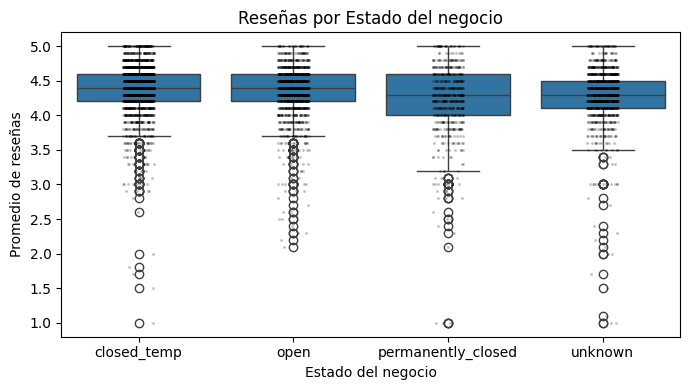

In [52]:
plt.figure(figsize=(7,4))
sns.boxplot(data=df, x="state", y="avg_rating")
sns.stripplot(data=df, x="state", y="avg_rating", size=2, alpha=0.25, color="black")
plt.xlabel("Estado del negocio")
plt.ylabel("Promedio de reseñas")
plt.title("Reseñas por Estado del negocio")
plt.tight_layout()
plt.show()

Se puede observar que en general el estado del negocio, si está abierto, cerrado temporalmente, cerrado permanentemente o se desconoce el estado, no influye considerablemente en el promedio de reseñas que se obtiene.

Sin embargo, sí se puede notar una ligera diferencia con el estado desconocido y más considerablemente en el estado de cerrado permanentemente.

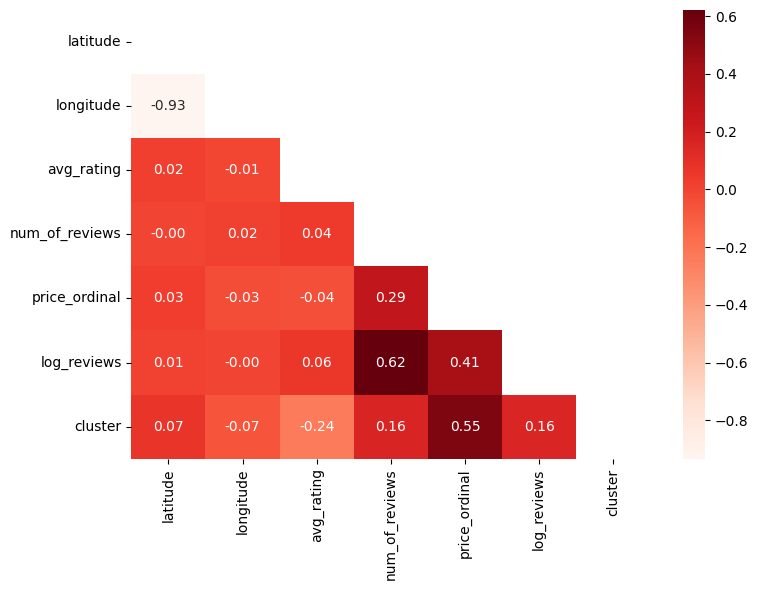

In [56]:
numeric_df = df.select_dtypes(include=[np.number])
corr = numeric_df.corr()

plt.figure(figsize = (8,6))
sns.heatmap(corr,
            mask = np.triu(corr),
            annot = True,
            fmt = ".2f",
            cmap = "Reds",
            cbar = True)

plt.tight_layout()
plt.show()

Hay una fuerte correlación entre num_of_reviews y log_reviews. También, a mayor precio en la panadería, mayor cantidad de reseñas tiene, lo que sugiere existen factores como la calidad o el servicio.

###Propuesta de negocio

**¿Dónde conviene abrir nuevas panaderías o reposicionar las actuales en California?**

1. Vamos a agrupar (clustering) todas las panaderías de California usando su ubicación, su nivel de calificación, el número de reseñas (demanda) y su nivel de precio.

¿Para qué?

1. Detectar zonas saturadas: lugares donde hay demasiadas panaderías compitiendo entre sí.

2. Encontrar oportunidades: áreas con poca competencia, pero con buena demanda alrededor.

3. Clasificar tipos de zonas: por ejemplo, zonas de panaderías baratas pero bien calificadas, vs. zonas de panaderías caras pero con reseñas bajas.

Con eso nosotros podemos:

* Abrir en zonas de oportunidad.

* Reposicionar en zonas saturados.

* Adquirir locales cerrados en zonas con buena demanda.

Con los datos que tenemos, podemos usar:

`rating` = satisfacción de clientes.

`num_of_reviews` = popularidad o demanda.

`price` = tipo de mercado (low, medium, high).

`lat/long` = competencia y cercanía.

`state` = si está abierto, cerrado temporal o permanente.

Con esto, el clustering nos ayuda a mapear el mercado y crear segmentos de panaderías para saber cómo competir y dónde expandirse.

### Metodología de Ciencia de Datos

In [36]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

#1)Features
#convertimos el price de categorico a numerico
price_ordinal_map = {"low": 0, "medium": 1, "high": 2, "unknown": 1}  #categoria "unknown" la tomamos como "medium"
df["price_ordinal"] = df["price"].map(price_ordinal_map).astype(float)

#transformamos el número de reseñas con logaritmos
#por que asi podemos reducir el efecto de panaderias con muchas reseñas que podrian desbalancear al modelo
df["log_reviews"] = np.log1p(df["num_of_reviews"])

# Matriz de características
X = df[["latitude", "longitude", "avg_rating", "log_reviews", "price_ordinal"]].copy()



In [37]:
# Escalado de variables
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [38]:
#2) Selección de K
#probamos diferentes numeros de cluster (5-20)
sil_scores = []
ks = list(range(5, 21))
for k in ks:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_scaled)
    #que tan separados o compactos estan los grupos
    sil = silhouette_score(X_scaled, labels)
    sil_scores.append((k, sil))

#elegimos el mejor numero de K con el puntaje mas alto de silhoutte
best_k, best_sil = max(sil_scores, key=lambda x: x[1])
print(f"Mejor K: {best_k}  |  Silhouette: {best_sil:.3f}")

Mejor K: 5  |  Silhouette: 0.397


In [39]:
# 3) Entrenamiento
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
df["cluster"] = kmeans.fit_predict(X_scaled)

# calculamos los centroides (promedio de cada grupo)
centroids_scaled = kmeans.cluster_centers_
centroids = pd.DataFrame(scaler.inverse_transform(centroids_scaled), columns=X.columns)
centroids["cluster"] = range(best_k)

print("\nCentroides:")
display(centroids)


Centroides:


,latitude,longitude,avg_rating,log_reviews,price_ordinal,cluster
0,33.930069,-118.017428,4.450993,4.157250,0.001453,0
1,37.964727,-121.864588,4.340782,5.483964,1.036313,1
2,37.808780,-121.772166,4.423775,4.062690,0.001441,2
3,34.939059,-118.962293,3.318850,2.584442,0.067093,3
4,33.907580,-117.996014,4.329875,5.410790,1.020173,4


In [40]:
#Saca la categoria mas común de una columna
def mode_or_nan(s):
    vc = s.value_counts()
    return vc.index[0] if len(vc) else np.nan
#Para cada cluster
cluster_profile = (
    df.groupby("cluster").agg(
        n=("name","count"), #Cuantas panaderias tiene n
        lat_mean=("latitude","mean"),#Lat/log promedio
        lon_mean=("longitude","mean"),
        rating_mean=("avg_rating","mean"),#calificacion promedio
        reviews_median=("num_of_reviews","median"),#mediana de reseñas
        price_mode=("price", mode_or_nan),#Precio mas comun
        open_pct=("state", lambda x: (x=="open").mean()),#porcentaje de negocios abiertos
        closed_temp_pct=("state", lambda x: (x=="closed_temp").mean()),#cerrado temp
        perm_closed_pct=("state", lambda x: (x=="permanently_closed").mean())#cerrados
    )
    .sort_values("n", ascending=False)
)

print("\nPerfil por clúster:")
display(cluster_profile)


Perfil por clúster:


,n,lat_mean,lon_mean,rating_mean,reviews_median,price_mode,open_pct,closed_temp_pct,perm_closed_pct
cluster,,,,,,,,,
0,2065,33.930069,-118.017428,4.450993,68.0,low,0.324939,0.398547,0.095884
2,1388,37.808780,-121.772166,4.423775,58.0,low,0.233429,0.464697,0.119597
4,1041,33.907580,-117.996014,4.329875,255.0,medium,0.222863,0.333333,0.087416
1,716,37.964727,-121.864588,4.340782,291.5,medium,0.208101,0.371508,0.085196
3,313,34.939059,-118.962293,3.318850,13.0,low,0.265176,0.306709,0.255591


In [41]:
import plotly.express as px

fig = px.scatter_mapbox(
    df,
    lat="latitude",
    lon="longitude",
    color="cluster",
    hover_name="name",
    hover_data={"avg_rating":True,"num_of_reviews":True,"price":True,"state":True},
    zoom=5.2, height=650
)
fig.update_layout(mapbox_style="open-street-map", title="Clústeres de panaderías en California")
fig.show()


Cada panaderia aparece como un punto en el mapa y el color indica a que cluster pertenece

In [42]:
summary = cluster_profile[["rating_mean","reviews_median","price_mode","open_pct","closed_temp_pct","perm_closed_pct"]].round(2)
print("\nResumen compacto por clúster:")
display(summary)


Resumen compacto por clúster:


,rating_mean,reviews_median,price_mode,open_pct,closed_temp_pct,perm_closed_pct
cluster,,,,,,
0,4.45,68.0,low,0.32,0.40,0.10
2,4.42,58.0,low,0.23,0.46,0.12
4,4.33,255.0,medium,0.22,0.33,0.09
1,4.34,291.5,medium,0.21,0.37,0.09
3,3.32,13.0,low,0.27,0.31,0.26


## Resultados

El algoritmo KMeans agrupó las panaderías en **5 segmentos** diferentes según ubicación, calificación, reseñas y nivel de precios. Cada clúster representa un “tipo de zona de panaderías”.

### Clúster 0 – Panaderías accesibles y bien calificadas (Zona Sur de California)
- **Cantidad:** 2065 panaderías (el grupo más grande).  
- **Precio típico:** low (barato).  
- **Rating promedio:** 4.45 (alto).  
- **Mediana reseñas:** 68 (demanda moderada).  
- **Estados:** 40% cerradas temporalmente, 32% abiertas.  
- **Interpretación:** muchas panaderías económicas con buena calidad, pero alta rotación de estado (cerradas por horarios). Zona con **mucha oferta y competencia**.  

---

### Clúster 2 – Panaderías locales dispersas (Área de la Bahía / Valle Central)
- **Cantidad:** 1388 panaderías.  
- **Precio típico:** low.  
- **Rating promedio:** 4.42 (alto).  
- **Mediana reseñas:** 58 (menos reseñas que clúster 0).  
- **Estados:** 46% cerradas temporalmente, 23% abiertas.  
- **Interpretación:** panaderías baratas, bien evaluadas, pero con menor flujo de clientes. Mercado más fragmentado.  

---

### Clúster 4 – Panaderías medianas con alta demanda (Los Ángeles / Orange County)
- **Cantidad:** 1041 panaderías.  
- **Precio típico:** medium.  
- **Rating promedio:** 4.33 (bueno).  
- **Mediana reseñas:** 255 (muy alto, mucha demanda).  
- **Estados:** 33% cerradas temporalmente, 22% abiertas.  
- **Interpretación:** zona de panaderías de **precio medio y muy populares**. Aquí hay mayor concentración de clientes y competencia más fuerte. Ideal para negocios diferenciados (gourmet o especialidad).  

---

### Clúster 1 – Panaderías medianas con demanda alta (Área de la Bahía de San Francisco)
- **Cantidad:** 716 panaderías.  
- **Precio típico:** medium.  
- **Rating promedio:** 4.34.  
- **Mediana reseñas:** 291.5 (alto).  
- **Estados:** 37% cerradas temporalmente, 21% abiertas.  
- **Interpretación:** panaderías de **precio medio con alta popularidad** en la zona de la Bahía. Mercado interesante pero muy competitivo.  

---

### Clúster 3 – Panaderías con bajo rating y baja demanda (Zonas rurales)
- **Cantidad:** 313 panaderías (el grupo más pequeño).  
- **Precio típico:** low.  
- **Rating promedio:** 3.32 (bajo).  
- **Mediana reseñas:** 13 (muy poca demanda).  
- **Estados:** 25% cerradas permanentemente, 31% cerradas temporalmente.  
- **Interpretación:** panaderías de baja calidad y poco tráfico, ubicadas en zonas menos pobladas. **No recomendable** para expansión.  





## Conclusiones de negocio
- **Zonas de oportunidad:** clústeres 1 y 4 (precio medio, alta demanda, ratings buenos). Conviene expandir con productos diferenciados.  
- **Mercado masivo:** clúster 0 (precio bajo, buena calidad, competencia fuerte). Solo conviene entrar con propuesta innovadora.  
- **Mercados riesgosos:** clúster 3 (ratings bajos, baja demanda). Mejor evitar inversión aquí.  
- **Mercados emergentes:** clúster 2 (baratas, buenas calificaciones pero pocas reseñas). Potencial a mediano plazo si crece la demanda.  